In [159]:
from ase.io import read, write 
from ase import atoms 
from ase.io.vasp import read_vasp
from ase.visualize import view
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
import random
import numpy as np
from ase.md import MDLogger
from ase.md.npt import NPT
from ase import units
from mace.calculators import mace_mp, MACECalculator
from tqdm import tqdm
from ase.md.analysis import DiffusionCoefficient
import os
import matplotlib.pyplot as plt
from ase.build import make_supercell
from ase.optimize import LBFGS
from ase.constraints import UnitCellFilter

In [3]:
import utils.diff_coeff as diff

# About the notebook
In this notebook, you will get a small introduction into how you can launch and use the MACE-MP-0 calculator to run Nose-Hoover NVT Molecular Dynamics.

# 1.1) Atoms Object
In this first step, lets first begin by visualising the g-Li3PS4 structure

In [8]:
g_li3ps4 = read('g_li3ps4.xyz')
view(g_li3ps4, viewer='ngl')

# 1.2) MACE-MP-0 Calculator
In this next step, we will initialise the MACE-MP0-0 calculator. MACE provides 2 calculators the 'mace_mp' and the MACECalculator, the first is spcecific to launching the MACE-MP-0 models and is what we will be using today. Whit the second calculator any MACE model can be used, this includes the MACE-MP-0 models. In the program you will use later, both are implemented

In [9]:
from mace.calculators import mace_mp, MACECalculator


#MACE-MP-0 calculator parameters

model = 'small' # defines the MACE-MP-0 model that is to be used small, medium or large
device = 'cpu'  # states what to use for calculation cpu or cuda, for gpu
default_dtype = 'float32' # defines the dtype for the calculation float32 or float64. 
                          # float32 is less accurate but faster



calc = mace_mp(model=model, device=device, default_dtype=default_dtype)

Using Materials Project MACE for MACECalculator with /home/chem/msufwc/.cache/mace/46jrkm3v
Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.
Default dtype float32 does not match model dtype float64, converting models to float32.


# 1.3) Nose-Hoover NVT Molecular Dynamics
We can then attach this calculator to our structure and run some NVT MD. In the provided program, only Nose-Hoover NVT is supported and all parameters are representative of this choice. The provided program exploits ASE's Nose-Hoover implementation which is actually an ASE NPT model that has the barostat disabled. The program disables this by default but this can be modified, and NPT dynamics run by modifying the mace_nvt.py file to include a barostat.

In [16]:
g_li3ps4.calc = calc


# NVT molecular dynamics input parameters
temp = 800 # temperature to run the MD at
ts = 2*units.fs # timestep of the MD
tts = 80*units.fs # characteristic timestep of the thermostast, a good value is 40*time step
step = 10 # number of MD steps to simulate




# defines file to save the trajectory, time, and temperature too
temp_arr = []
time_arr = []

def write_frame():
    dyn.atoms.write('test_mace_md.xyz', append=True)
    time_arr.append(dyn.get_time())
    temp_arr.append(dyn.atoms.get_temperature())
## initialise the MD
MaxwellBoltzmannDistribution(g_li3ps4, temperature_K=temp)
dyn = NPT(g_li3ps4, externalstress=1., timestep =ts, ttime=tts, temperature_K=temp)
dyn.attach(write_frame, interval=1)

## run MD
dyn.run(int(step))

f = open('test_mace_md_temp.txt', 'w')

for i in range(len(temp_arr)):
    f.write(str(time_arr[i]) + ' ' + str(temp_arr[i]) + '\n')
f.close()




# 1.4) Diffusion constant
From this MD, we can then extract a diffusion constant. This is done by calculating the Mean Square Displacement and then the gradient of the resulting plot. This value is what we will later plot and calculate

In [18]:
trajectory = read('test_mace_md.xyz', index = ':')
ts = 2*units.fs # timestep of the MD
atom = 'Li' # atom to calculate the diffusion constant for
start = 0 # which frame of the trajectory to start calcualting from, can be used to ignore the initial equilibration
diffusion_coeff = diff.get_diffusion_coeff(trajectory, timestep=ts, atom=atom, start=start)
print('The diffusion coefficient at',temp,'K was:', diffusion_coeff,'cm^2/S')

The diffusion coefficient at 800 K was: 2.369005451245663e-05 cm^2/S


# 2) Diff_Coeff
In this next section, you will use the diff_coeff.py file that is found in utils to run MD using MACE-MP-0. The aim is to run it for multiple temperatures with multiple repeats at each temperature. This will allow us to calculate an average temperature, with errors, and extrapolate to a room temperature diffusion constant, while proppogating the errors.

# 2.1 Basic Script
The first place to start is the diffusion_plot() function found in diff_coeff.py. This function automates the running, caclculation and extrapolation of dissplacement constants and serves as an example of how to set up the system.

In [19]:
def diffusion_plot(structure_file,temp_arr=[525], repeats=5, ts=2*units.fs, tts=80*units.fs, step=100, atom='Li', start=0, model='medium', floats='float32'):
    #set up and run the md, in this case the paralel cpu implementation
    diff.run_md_bash(structure, temp_arr, repeats, ts, tts, step, model, floats)
    
    #read in the diffusion coefficients from the generated files
    dict_diff_coeff = diff.extract_diff_coeff(temp_arr, repeats, atom, start, ts)
    
    #plot the diffusion constants and extract the coefficients, covarience 
    coefficients,cov = diff.plot_average_diff_coeff(dict_diff_coeff)
    return coefficients, dict_diff_coeff,cov


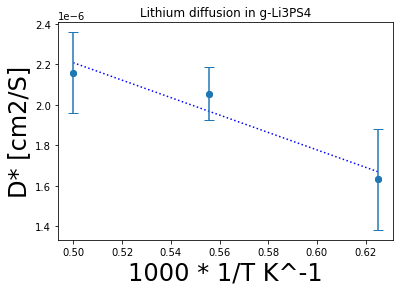

The estimated room temperature difussion coefficient  -9.994372044189332e-06  +-  2.400373442689254e-06  cm2/s


In [20]:
# using the function found in diff_coeff.py to run all the MD
# and extract the diffusion constants
# here we run at high temperatures to avoid file clashes with later steps
# where we will use temperatures 800-1400K
coefficients,dict_diff_coeff,cov = diff.diffusion_plot(
    structure_file='g_li3ps4.xyz',
    temp_arr=[1600,1800,2000], 
    repeats=5, 
    ts=2*units.fs, 
    tts=80*units.fs, 
    step=10, 
    atom='Li', 
    start=0, 
    model='small', 
    floats='float32',
    device='cpu'
    )


# a function that extrapolates the room temperature diffusion constant
# given the line on best fit and the covarience matrix of the fitted
# data in the above step
room_diff_coeff,err = diff.room_temp_diff_coeff(coefficients, cov ,300)
print('The estimated room temperature difussion coefficient ', room_diff_coeff,' +- ',err,' cm2/s')

# 2.2 Parameters
When defining your diffusion plot function, ie a function that brings together the many functions found in diff_coeff.py, there are some options.

The first of this is how you run the MD
You have an option of run_md_bash or run_md. the run md option will simply run the vairous temperatures and repeats sequentially, this is good for GPUs where the calculations will use the whole GPU and will run faster. run_md_bash works by first making a bash script that attempts to launch all temperature and repeats at the same time. This is well suited to cpu where MACE can only use one core, this in effect allows us to parallelise calculations


Following this, we also have a choice in what you wish to plot, the choice here is between plot_average_diff_coeff and plot_diff_coeff. plot_diff_coeff will plot all calculated diffusion constants, and plot_average_diff_coeff will plot the average diffusion constant at a given temperature, with error bars to represent the stnadard deviation. Both will calculate a line of best fit and output the coefficients and the covariance matrix.

## Good To Know
feel free to play around with some of the parameters but keep in mind that making the models larger will make them more expensive. another consideration for evaluation on hetmathsys is that there are only 40 cores available, as such the length of your temperature array * the number of repitions should ideally be below 40 as the runs will be launched at the same time and will each require 1 cpu. In the case that you want to do more than 40 total calculations this is possible by splitting up the calculations like shown below

In [ ]:
structure_file='g_li3ps4.xyz'
repeats=10
ts=2*units.fs
tts=80*units.fs 
step=10
atom='Li'
start=0
model='small'
floats='float32'
device='cpu'



#set up and run the md, in this case the paralel cpu implementation

temp_arr=[100,200,300,400]
diff.run_md_bash(structure_file, temp_arr, repeats, ts, tts, step, model, floats, device)

temp_arr=[500,600,700,800]
diff.run_md_bash(structure_file, temp_arr, repeats, ts, tts, step, model, floats, device)



#read in the diffusion coefficients from the generated files
temp_arr=[100,200,300,400,500,600,700,800]
dict_diff_coeff = diff.extract_diff_coeff(temp_arr, repeats, atom, start, ts)

#plot the diffusion constants and extract the coefficients, covarience 
coefficients,cov = diff.plot_average_diff_coeff(dict_diff_coeff)

room_diff_coeff,err = diff.room_temp_diff_coeff(coefficients, cov ,300)
print('The estimated room temperature difussion coefficient ', room_diff_coeff,' +- ',err,' cm2/s')

you can see above that for the calculations we can give multiple sets of arrays to each run, and combine the temperature arrays when we come to extracting the coefficients. this is because when the MD is run, it is saved to a file name including the temperature and repetition. For this to work you need to ensure number of repitions is consistent in each run. note that running the simulation again will overwrite the saved trajectory files.

# 2.3 Reproducible Result Run
Finally for the reproducible result, you are welcome to experiment with some parameters, you should do 1 production run at 800K,1000K,1200K and 1400K. using 5 repitions and 10,000 steps per MD. from this you should plot the graph of the diffusion constants and extract the diffusion constant at 300K compare this to a precalculated value made using the same parameters. The other paremeters are specified below.

In [ ]:
coefficients,dict_diff_coeff,cov = diff.diffusion_plot(
    structure_file='g_li3ps4.xyz',
    temp_arr=[800,1000,1200,1400], 
    repeats=5, 
    ts=2*units.fs, 
    tts=80*units.fs, 
    step=10000, 
    atom='Li', 
    start=0, 
    model='medium', 
    floats='float32',
    device='cpu'
    )

room_diff_coeff,err = diff.room_temp_diff_coeff(coefficients, cov ,300)
print('The estimated room temperature difussion coefficient ', room_diff_coeff,' +- ',err,' cm2/s')

In the case that your calculations have already run and you wish to avoid rerunning use the following cells

In [5]:
# same parameters as above
structure_file='g_li3ps4.xyz'
temp_arr=[800,1000,1200,1400]
repeats=5
ts=2*units.fs 
tts=80*units.fs 
step=10000
atom='Li' 
start=0
model='medium' 
floats='float32'
device='cpu'

#read in the diffusion coefficients from the generated files
dict_diff_coeff = diff.extract_diff_coeff(temp_arr, repeats, atom, start, ts)

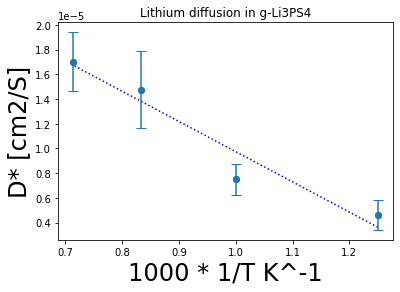

The estimated room temperature difussion coefficient  -4.7295302687762855e-05  +-  9.946630496785827e-06  cm2/s


In [6]:
#plot the diffusion constants and extract the coefficients, covarience
#this plot takes an average value at each temperatue and plots the standard deviation as the error bars
coefficients,cov = diff.plot_average_diff_coeff(dict_diff_coeff)

#extract the room temperature diffusion coefficient
room_diff_coeff,err = diff.room_temp_diff_coeff(coefficients, cov ,300)
print('The estimated room temperature difussion coefficient ', room_diff_coeff,' +- ',err,' cm2/s')

[-2.44422848e-05  3.41789801e-05] [[ 8.62987235e-12 -8.19324191e-12]
 [-8.19324191e-12  8.12750273e-12]]


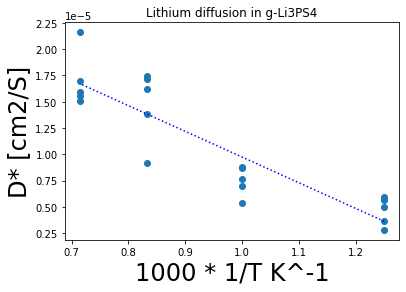

The estimated room temperature difussion coefficient  -4.7295302687762855e-05  +-  9.946630496785827e-06  cm2/s


In [7]:
#plot the diffusion constants and extract the coefficients, covarience
#this plot shows all calcualted diffusion constants
coefficients,cov = diff.plot_diff_coeff(dict_diff_coeff)

#extract the room temperature diffusion coefficient
room_diff_coeff,err = diff.room_temp_diff_coeff(coefficients, cov ,300)
print('The estimated room temperature difussion coefficient ', room_diff_coeff,' +- ',err,' cm2/s')

# Analysis of the result
The precalculated extrapolated room temperature difussion coefficient was -4.7597e-05 cm^2/S  +-  1.0264e-05  cm^2/s


You can see that the error on this is quite high, this could be improved with more repeats, a larger MACE-MP-0 model and longer trajectories. However it also shows MACE-MP-0s main limitation where the training set has no data on structures at non 0K temperatures and as such we do not expect it to perform perfectly.

The experimental value that is quoted is typically on the 10^-7 order of magnitude. While we can see that we are not miles away we are certainly not close to that and MACE-MP-0 predicts higher mobility of the Lithium ions.

Finally, this shows that despite limitations in the data set, it is remarkably stable. It also shows that for accurate results, this foundation model will need to be fine tuned to get more accurate results.

# Possible sources of error (size effects)
A possible source of error is the size of the cell that is being examined, this becomes particularly important if you begin to look at interfaces between two bulk structures. This difference can be down to the missmatch between the lattice parameters of the two bulks. In the case of looking at one bulk, you can also see differences emerge in the density of the cell, this in turn can impact the energy and forces and as a result the diffusion constants associated with the system.

A full investigation of the size effects on the diffusion constant would take too long to implement in this resproducible result but can be demostrated by doing geometry optimisations of various supercells of Li3PS4.

# 3.1 Primitive cell 
Below you can see the primitive cell for Li3PS4, the cell and geometry has been optimised using VASP and the same conditions as the structure used previously. In this next section you are free to generate and run the geometry optimisation for various Li3PS4 supercells and see how that impacts the density and the energy per atom of the system.

In [160]:
# read in the primitive cell
prim = read('g_li3ps4_prim_opt.xyz')
view(prim, viewer='ngl')

In [163]:
# set up a mace mp calculator. here we use medium float 64 as for better accuracy 
# but you can switch to small float 32 if you need a faster system
calc = mace_mp('small', default_dtype='float64', device='cpu')

Using Materials Project MACE for MACECalculator with /home/chem/msufwc/.cache/mace/46jrkm3v
Using float64 for MACECalculator, which is slower but more accurate. Recommended for geometry optimization.


# 3.2 Geometry Optimisation
Here you can make supercells, run geometry optimisations including cell relaxations and extract the densities. The default is to vary a to make supercells of repitions of (a,a,a). to vary them independantly uncomment the commented lines

In [164]:
a = 3
b = 3
c = 3
len_atom = []
energy_per_at = []
volume_arr = []
density_arr = []
for i in range(a):
#     for j in range(b):
#         for k in range(c):
            make = [[i+1,0,0],[0,i+1,0],[0,0,i+1]]
#             make = [[i+1,0,0],[0,j+1,0],[0,0,k+1]]
            super_cell = make_supercell(prim, make)
            super_cell.calc = calc
            sf = UnitCellFilter(super_cell)
            dyn = LBFGS(sf)
            dyn.run(fmax=0.01)
            volume_arr.append(super_cell.cell.volume)
            density_arr.append(len(super_cell)/super_cell.cell.volume)
            energy = super_cell.get_potential_energy()
            print(energy/len(super_cell), ' ev/atom', make)
            len_atom.append(len(super_cell))
            energy_per_at.append(energy/len(super_cell))


       Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
LBFGS:    0 17:11:48      -70.251369*       0.1422
LBFGS:    1 17:11:49      -70.253406*       0.1340
LBFGS:    2 17:11:49      -70.259281*       0.1135
LBFGS:    3 17:11:49      -70.260742*       0.1368
LBFGS:    4 17:11:49      -70.267848*       0.1828
LBFGS:    5 17:11:50      -70.274328*       0.1501
LBFGS:    6 17:11:50      -70.280381*       0.1306
LBFGS:    7 17:11:50      -70.283054*       0.0982
LBFGS:    8 17:11:50      -70.284913*       0.1036
LBFGS:    9 17:11:51      -70.287351*       0.1145
LBFGS:   10 17:11:51      -70.290120*       0.1216
LBFGS:   11 17:11:51      -70.292745*       0.1259
LBFGS:   12 17:11:51      -70.294620*       0.0822
LBFGS:   13 17:11:51      -70.295632*       0.0783
LBFGS:   14 17:11:52      -70.296186*       0.0622
LBFGS:   15 17:11:52      -70.296538*       0.0427
LBFGS:   16 17:11:52      -70.296899*       0.0661
LBFGS:   17 17:11:52      -70.2974

LBFGS:   37 17:18:08    -1897.527739*       0.0752
LBFGS:   38 17:18:15    -1897.549090*       0.0746
LBFGS:   39 17:18:21    -1897.570734*       0.0835
LBFGS:   40 17:18:27    -1897.594533*       0.0908
LBFGS:   41 17:18:33    -1897.621211*       0.0930
LBFGS:   42 17:18:39    -1897.650529*       0.0899
LBFGS:   43 17:18:46    -1897.681559*       0.0817
LBFGS:   44 17:18:52    -1897.712758*       0.0783
LBFGS:   45 17:18:58    -1897.741917*       0.0694
LBFGS:   46 17:19:04    -1897.766045*       0.0501
LBFGS:   47 17:19:11    -1897.779639*       0.0447
LBFGS:   48 17:19:17    -1897.787924*       0.0467
LBFGS:   49 17:19:23    -1897.807574*       0.0539
LBFGS:   50 17:19:29    -1897.829121*       0.0658
LBFGS:   51 17:19:36    -1897.862220*       0.0805
LBFGS:   52 17:19:42    -1897.889053*       0.0682
LBFGS:   53 17:19:48    -1897.906011*       0.0492
LBFGS:   54 17:19:54    -1897.918471*       0.0378
LBFGS:   55 17:20:00    -1897.928012*       0.0386
LBFGS:   56 17:20:07    -1897.9

In [167]:
density_arr = []
for i in range(3):
    density_arr.append(len_atom[i]/volume_arr[i])

In [168]:
# this will print a nice summary of the results 
for i in range(3):
    print(len_atom[i],' atoms, ',energy_per_at[i],'eV/atom, ',volume_arr[i],'A^3 volume, ', density_arr[i], 'atoms/A^3 density ')


16  atoms,  -4.393705991906485 eV/atom,  322.648195118725 A^3 volume,  0.049589615693069265 atoms/A^3 density 
128  atoms,  -4.393727053694645 eV/atom,  2579.5649956003012 A^3 volume,  0.049620769477922225 atoms/A^3 density 
432  atoms,  -4.393664865698732 eV/atom,  8707.834415846437 A^3 volume,  0.04961049778505783 atoms/A^3 density 



# 3.3 Summary

Here is a list of values i have computed previously using an fmax of 0.01 with MACE-MP medium float64 for (1,1,1), (2,2,2), and (3,3,3) supercells.

16  atoms,  -4.393117949388361 eV/atom,  325.4541311595248 A^3 volume,  0.04916207375520278 atoms/A^3 density 

128  atoms,  -4.393104722757153 eV/atom,  2603.196427284316 A^3 volume,  0.04917031948047464 atoms/A^3 density 

432  atoms,  -4.393089194773834 eV/atom,  8782.439280276862 A^3 volume,  0.04918906766257557 atoms/A^3 density 

.

.


Here is a list of values i have computed previously using an fmax of 0.01 with MACE-MP small float64 for (1,1,1), (2,2,2), and (3,3,3) supercells.

16  atoms,  -4.393705991906485 eV/atom,  322.648195118725 A^3 volume,  0.049589615693069265 atoms/A^3 density 

128  atoms,  -4.393727053694645 eV/atom,  2579.5649956003012 A^3 volume,  0.049620769477922225 atoms/A^3 density 

432  atoms,  -4.393664865698732 eV/atom,  8707.834415846437 A^3 volume,  0.04961049778505783 atoms/A^3 density 

 
.

.


As you can see the systems get progresively more dense as the supercell increases in size. This could be explained by the fact that in these larger system there are more atoms free to move indendantly, as opposed to smaller cells where preriodic boundary conditions mean that way atoms can move is more correlated. Since the density changes, this will be result in changes in the "bond lengths" seen in the system meaning that each atom sits in a new enviroment and will have a different energy and force. This is a big limitation in simulations as larger systems are more costly to simulate.


You can also see that depending on the model used, increasing in size of the model, the density and energy, and therefore diffusion constant changes. This error is hard to quantify in terms of the error in the weights involved the foundation model however differences in the diffusion contsant can de demostrated in the above code by changing the specified calculator.

There are also other parameters that will affect the error in the diffusion constant that are equally hard to investigate in this format. This includes the DFT paramters used to generate the training set, such as the energy cutoff the K-point sampling density and the functional used. This will impact how converged the calculated, and therefore predicted values are in the MLIP, however there is not enough time to do convergence tests and model training. Furthermore, parameters affecting the size of the model beyond the level of the message pass will also affect the accuracy of how well the MLIP reproduces the DFT data. 